# Vertically Integrated Heat Content and tendency accumulation in ACCESS-OM2

### Theory
Consider the vertically-integrated heat budget:

\begin{equation}
\frac{\partial H}{\partial t}(x,y,t) = T + Q, \label{dHdt}
\end{equation}

where, $$H(x,y,t) = \int_{-H}^\eta \rho_0 C_p \Theta dz$$ is the vertically-integrated heat content (Jm$^{-2}$), $T=-\nabla_h\cdot\mathbf{F}_O$ is the convergence of the vertically-integrated horizontal ocean heat transport ($\mathbf{F}_O$) and $Q$ is the net surface heat flux (both Wm$^{-2}$).

Integrating Eq. $\eqref{dHdt}$ between two times $t_1$ and $t_2$ yields:
$$\Delta_{t_1}^{t_2} H = H(x,y,t_2)-H(x,y,t_1) = \int_{t_1}^{t_2} T dt + \int_{t_1}^{t_2} Q dt = (t_2-t_1)(\overline{T}+\overline{Q})$$
Thus the change in heat content is given by the average of the ocean heat transport and surface heat flux tendency terms over the interim period multiplied by the length of that interim period.

There are two problems with using the above equation:

1. A large cancelation between $\overline{T}$ and $\overline{Q}$ means that $\Delta H$ is unlikely to look like either $\overline{T}$ or $\overline{Q}$. One option to deal with this is to subtract off some type of average ocean heat transport $T_A$ (we choose $T$ rather than $Q$ for this because it integrates globally to zero):
$$\Delta_{t_1}^{t_2}H = (t_2-t_1)(\overline{T}-T_A)+(t_2-t_1)(\overline{Q}+T_A) = (t_2-t_1)\Delta T + (t_2-t_1)\Delta Q$$
Obviously if we pick $T_A=\overline{T}$ then we get back to the previous equation. The best pick for $T_A$ would be a long-term average from a balanced PI-control run or a pre-CC period.

2. The change in heat content is sensitive to short time-scale variability because the end periods are snapshots.

To deal with the second issue, a better approach would be to consider the change in heat content between two decadal-scale averaging windows $(t_{11},t_{12})$ and $(t_{21},t_{22})$, where we assume for simplicity that $t_{22}-t_{21}=t_{12}-t_{11}=\Delta t$. The change in heat content between these two periods obeys,

\begin{align}
\Delta_{t_{11},t_{12}}^{t_{21},t_{22}} H &= \frac{1}{\Delta t}\int_{t_{21}}^{t_{22}} H dt - \frac{1}{\Delta t}\int_{t_{11}}^{t_{12}} H dt \\
&= \frac{1}{\Delta t}\int_{t_{21}}^{t_{22}} \left(H(t) - H(t_{21})\right) dt +H(t_{21}) + \frac{1}{\Delta t}\int_{t_{11}}^{t_{12}} \left(H(t_{12}) -H(t)\right) dt -H(t_{12}) \\
&= \frac{1}{\Delta t}\int_{t_{21}}^{t_{22}} \int_{t_{21}}^t \left(T+Q\right) dt' dt + \frac{1}{\Delta t}\int_{t_{11}}^{t_{12}} \int_{t}^{t_{12}} \left(T+Q\right) dt' dt + \int_{t_{12}}^{t_{21}} \left(T+Q\right) dt \\
&= -\frac{1}{\Delta t}\int_{t_{21}}^{t_{22}} \int_{t}^{t_{22}} \left(T+Q\right) dt' dt - \frac{1}{\Delta t}\int_{t_{11}}^{t_{12}} \int_{t_{11}}^t \left(T+Q\right) dt' dt + \int_{t_{11}}^{t_{22}} \left(T+Q\right) dt \\
\end{align}

The second last line expresses the change in heat content in terms of the transport and surface heat fluxes over the interim period (last term), and over the individual window-averaging periods (first two terms, which involve double time integrals). The last line rewrites this in terms of the transport and surface heat fluxes over the whole period (last term). Further, we can integrate the two time integrals by parts to turn them into single time-integrals,

\begin{align}
\int_{t_{21}}^{t_{22}}\int_t^{t_{22}}(T+Q)dt'dt &= \int_{t_{21}}^{t_{22}}(t-t_{21})(T+Q)dt \\
\int_{t_{11}}^{t_{12}}\int_{t_{11}}^t(T+Q)dt'dt &= \int_{t_{11}}^{t_{12}}(t_{12}-t)(T+Q)dt \\
\end{align}

Substituting these in above yields,
\begin{equation}
\Delta_{t_{11},t_{12}}^{t_{21},t_{22}} H = -\frac{1}{\Delta t}\int_{t_{21}}^{t_{22}} (t-t_{21})\left(T+Q\right) dt + \frac{1}{\Delta t}\int_{t_{11}}^{t_{12}} (t-t_{12})\left(T+Q\right) dt + \int_{t_{11}}^{t_{22}} \left(T+Q\right) dt
\end{equation}

This shows that $\Delta H$ can also be interpreted as the full-average (last term) minus a rising and a falling weighted-average over the first and last periods. There are various other ways to write this. For example, one intuitive way is,

\begin{equation}
\Delta_{t_{11},t_{12}}^{t_{21},t_{22}} H = -\frac{1}{\Delta t}\int_{t_{21}}^{t_{22}} (t-t_{21})\left(T+Q\right) dt + \frac{1}{\Delta t}\int_{t_{11}}^{t_{12}} (t-t_{11})\left(T+Q\right) dt +\int_{t_{12}}^{t_{22}} \left(T+Q\right) dt
\end{equation}

I.e. an integral from the end of the first period to the end of the second period (last term), plus a rising integral over the first period (second term), subtracting a rising integral over the last period (first term). This form clearly shows that in terms of diagnostic code accumulation, we would only need to accumulate averages of $T+Q$ (already in place) and averages of $(t-t_i)(T+Q)$ where $t_i$ is the time at the beginning of the diagnostic accumulation period.

This type of average has been very roughly implemented (i.e. hacked) into MOM5 using the `diag_manager` from FMS as described below.

### Rising average maths in `diag_manager`

We wish to accumulate a rising average (denoted by $\overline{x}^r$) over the given diagnostic time period. In order to accumulate an average (as opposed to a sum in the last equation above) we need to divide by the diagnostic time period $\Delta t=t_f-t_0$ again. I.e., for a given quantity $A$ (say the surface heat flux in Wm$^{-2}$ above) we wish to calculate

\begin{equation}
\overline{A}^r \equiv \frac{1}{(\Delta t)^2}\int_{t_0}^{t_f}(t-t_0)A dt
\end{equation}

where $t_0$ and $t_f$ are the times at the beginning and ending of the diagnostic time period. Written as a discrete sum this is,

\begin{equation}
\overline{A}^r \equiv\frac{\Sigma_{i=1}^n(i - 1/2) dt A_i dt}{\left[\Sigma_{i=1}^n dt\right]^2}
\end{equation}

where $i$ is the step number, $dt$ is the time step and the $-1/2$ indicates that the time should be that associated with the middle of the time step (as A is accumulated over that time step).

Currently, the standard `average` method in `diag_manager` accumulates average variables $\overline{x}$ using the following maths

\begin{equation}
\overline{A} \equiv \frac{1}{\Delta t}\int_{t_0}^{t_f}A dt = \frac{A_c}{C} = \frac{\Sigma_{i=1}^n w_i A_i}{\Sigma_{i=1}^n w_i}
\end{equation}

where $w_i=1$ for the standard average. 

We can take advantage of this weighting system to approximately implement the rising average with very little code. We introduce a new option `risavg` that instead sets the weights equal to the time elapsed since the previous output,

\begin{equation}
w_i = t-t_0 = i dt
\end{equation}

where $dt$ is the time step. This should strictly be $(i-1/2)dt$ but that form is more difficult to implement. With this choice of $w_i$ the accumulated sum $A_C$ and the count $C$ become,

\begin{equation}
A_c = \Sigma_{i=1}^n i dt A_i, C = \Sigma_{i=1}^n i dt 
\end{equation}

To obtain an approximate discrete form of $\overline{A}^r$ above from these quantities we use the fact that,

\begin{equation}
C = dt \frac{n(n+1)}{2} \approx dt \frac{n^2}{2} = \frac{(\Sigma_{i=1}^n dt)^2}{2 dt}
\end{equation}

where the approximation holds for large $n$. Simlarly, the $-1/2$ can be dropped in the discrete form of $\overline{A}^r$ above for large $n$ yielding,

\begin{equation}
\overline{A}^r \approx \frac{dt A_c}{2 dt C} = \frac{A_c}{2C}
\end{equation}
where again, this only holds in the limit of large $n$. To achieve this in `diag_manager.F90` simply requires modifying the weights as above, and dividing by the factor of $2$ when the averaging count division is done. This rough hack is done in the `vitime` branch of my [MOM5 fork](https://github.com/rmholmes/MOM5/tree/vitime).

To remove the approximation that $n$ be large requires a more difficult coding exercise that can't (I don't think) just take advantage of the weights system in `diag_manager.F90`.

## Analysis

In [1]:
#Load required packages
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import cftime

import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import sys, os
import warnings
warnings.simplefilter("ignore") 

import cosima_cookbook as cc

from dask.distributed import Client

In [2]:
# Load workers:
client = Client(n_workers=4)
client

Client Scheduler: tcp://127.0.0.1:34382 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 33.67 GB


In [3]:
# Load session 
session = cc.database.create_session('../cc_database.db')

In [4]:
figdir = ''
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

In [5]:
# Define experiments
from collections import OrderedDict
exptdict = OrderedDict([
    ('1degRYFvitest',   {'model':'ACCESS-OM2 RYF', 'expt':'1deg_jra55_ryf_vitest',
                'n_files':None, 'itime': None,'ftime':None}),
])

### Structure data

In [146]:
ekey = '1degRYFvitest'
expt = exptdict[ekey]['expt']
n_files = exptdict[ekey]['n_files']

rho0 = 1035. # kgm-3
Cp = 3992.10322329649 # J kg-1 degC-1

A = cc.querying.getvar(expt,'area_t',session,n=n_files,decode_times=False,ncfile='ocean_grid.nc')

# timing
dt = 86400.*cc.querying.getvar(expt,'average_DT',session,n=n_files,decode_times=False,ncfile='ocean_month.nc')
time_avg = cc.querying.getvar(expt, 'time',session, n=n_files,ncfile='ocean_month.nc')
time_snap = cc.querying.getvar(expt, 'time',session, n=n_files,ncfile='ocean_snap.nc')

# scalars
Hg_scl = 1.e25*cc.querying.getvar(expt, 'total_ocean_heat',session, n=n_files,decode_times=False
                       ,ncfile='ocean_scalar.nc')

# Load variables:
H = Cp*cc.querying.getvar(expt, 'temp_int_rhodz',session, n=n_files,decode_times=False
                       ,ncfile='ocean_month.nc') # J m-2
Hsnap = Cp*cc.querying.getvar(expt, 'temp_int_rhodz',session, n=n_files,decode_times=False
                       ,ncfile='ocean_snap.nc') # J m-2

# surface heat flux:
Q = cc.querying.getvar(expt, 'sfc_hflux_coupler',session, n=n_files,decode_times=False
                       ,ncfile='ocean_month.nc') \
  + cc.querying.getvar(expt, 'sfc_hflux_pme',session, n=n_files,decode_times=False
                       ,ncfile='ocean_month.nc') \
  + cc.querying.getvar(expt, 'sfc_hflux_from_runoff',session, n=n_files,decode_times=False
                       ,ncfile='ocean_month.nc') \
  + cc.querying.getvar(expt, 'frazil_3d_int_z',session, n=n_files,decode_times=False
                       ,ncfile='ocean_month.nc')
Qra = cc.querying.getvar(expt, 'sfc_hflux_coupler',session, n=n_files,decode_times=False
                       ,ncfile='ocean_risavg.nc') \
  + cc.querying.getvar(expt, 'sfc_hflux_pme',session, n=n_files,decode_times=False
                       ,ncfile='ocean_risavg.nc') \
  + cc.querying.getvar(expt, 'sfc_hflux_from_runoff',session, n=n_files,decode_times=False
                       ,ncfile='ocean_risavg.nc') \
  + cc.querying.getvar(expt, 'frazil_3d_int_z',session, n=n_files,decode_times=False
                       ,ncfile='ocean_risavg.nc')

# ocean heat transport:
Fx = cc.querying.getvar(expt, 'temp_xflux_adv_int_z',session, n=n_files,decode_times=False
                       ,ncfile='ocean_month.nc') \
  + cc.querying.getvar(expt, 'temp_xflux_submeso_int_z',session, n=n_files,decode_times=False
                       ,ncfile='ocean_month.nc') \
  + cc.querying.getvar(expt, 'temp_xflux_gm_int_z',session, n=n_files,decode_times=False
                       ,ncfile='ocean_month.nc') \
  + cc.querying.getvar(expt, 'temp_xflux_ndiffuse_int_z',session, n=n_files,decode_times=False
                       ,ncfile='ocean_month.nc') \
  + cc.querying.getvar(expt, 'temp_sigma_diff_xflux_int_z',session, n=n_files,decode_times=False
                       ,ncfile='ocean_month.nc')
Fy = cc.querying.getvar(expt, 'temp_yflux_adv_int_z',session, n=n_files,decode_times=False
                       ,ncfile='ocean_month.nc') \
  + cc.querying.getvar(expt, 'temp_yflux_submeso_int_z',session, n=n_files,decode_times=False
                       ,ncfile='ocean_month.nc') \
  + cc.querying.getvar(expt, 'temp_yflux_gm_int_z',session, n=n_files,decode_times=False
                       ,ncfile='ocean_month.nc') \
  + cc.querying.getvar(expt, 'temp_yflux_ndiffuse_int_z',session, n=n_files,decode_times=False
                       ,ncfile='ocean_month.nc') \
  + cc.querying.getvar(expt, 'temp_sigma_diff_yflux_int_z',session, n=n_files,decode_times=False
                       ,ncfile='ocean_month.nc')
Sc = cc.querying.getvar(expt, 'temp_eta_smooth',session, n=n_files,decode_times=False
                       ,ncfile='ocean_month.nc') \
  + cc.querying.getvar(expt, 'mixdownslope_temp',session, n=n_files,decode_times=False
                       ,ncfile='ocean_month.nc').sum('st_ocean')
Fx_con = xr.concat([Fx.isel(xu_ocean=-1).fillna(0.),Fx.fillna(0.)],dim='xu_ocean').diff('xu_ocean').rename({'xu_ocean':'xt_ocean'}).assign_coords(xt_ocean=H.xt_ocean.values)
Fy_con = xr.concat([Fy.isel(yu_ocean=0).fillna(0.),Fy.fillna(0.)],dim='yu_ocean').diff('yu_ocean').rename({'yu_ocean':'yt_ocean'}).assign_coords(yt_ocean=H.yt_ocean.values)
T = -(Fx_con+Fy_con)/A + Sc

# ocean heat transport (ra):
Fxra = cc.querying.getvar(expt, 'temp_xflux_adv_int_z',session, n=n_files,decode_times=False
                       ,ncfile='ocean_risavg.nc') \
  + cc.querying.getvar(expt, 'temp_xflux_submeso_int_z',session, n=n_files,decode_times=False
                       ,ncfile='ocean_risavg.nc') \
  + cc.querying.getvar(expt, 'temp_xflux_gm_int_z',session, n=n_files,decode_times=False
                       ,ncfile='ocean_risavg.nc') \
  + cc.querying.getvar(expt, 'temp_xflux_ndiffuse_int_z',session, n=n_files,decode_times=False
                       ,ncfile='ocean_risavg.nc') \
  + cc.querying.getvar(expt, 'temp_sigma_diff_xflux_int_z',session, n=n_files,decode_times=False
                       ,ncfile='ocean_risavg.nc')
Fyra = cc.querying.getvar(expt, 'temp_yflux_adv_int_z',session, n=n_files,decode_times=False
                       ,ncfile='ocean_risavg.nc') \
  + cc.querying.getvar(expt, 'temp_yflux_submeso_int_z',session, n=n_files,decode_times=False
                       ,ncfile='ocean_risavg.nc') \
  + cc.querying.getvar(expt, 'temp_yflux_gm_int_z',session, n=n_files,decode_times=False
                       ,ncfile='ocean_risavg.nc') \
  + cc.querying.getvar(expt, 'temp_yflux_ndiffuse_int_z',session, n=n_files,decode_times=False
                       ,ncfile='ocean_risavg.nc') \
  + cc.querying.getvar(expt, 'temp_sigma_diff_yflux_int_z',session, n=n_files,decode_times=False
                       ,ncfile='ocean_risavg.nc')
Scra = cc.querying.getvar(expt, 'temp_eta_smooth',session, n=n_files,decode_times=False
                       ,ncfile='ocean_risavg.nc') \
  + cc.querying.getvar(expt, 'mixdownslope_temp',session, n=n_files,decode_times=False
                       ,ncfile='ocean_risavg.nc').sum('st_ocean')
Fxra_con = xr.concat([Fxra.isel(xu_ocean=-1).fillna(0.),Fxra.fillna(0.)],dim='xu_ocean').diff('xu_ocean').rename({'xu_ocean':'xt_ocean'}).assign_coords(xt_ocean=H.xt_ocean.values)
Fyra_con = xr.concat([Fyra.isel(yu_ocean=0).fillna(0.),Fyra.fillna(0.)],dim='yu_ocean').diff('yu_ocean').rename({'yu_ocean':'yt_ocean'}).assign_coords(yt_ocean=H.yt_ocean.values)
Tra = -(Fxra_con+Fyra_con)/A + Sc

In [150]:
# Load data
H.load()
Hsnap.load()
Q.load()
Qra.load()
T.load()
Tra.load()

# Calculate global integrals
Tg = (T*A).sum('xt_ocean').sum('yt_ocean')
Qg = (Q*A).sum('xt_ocean').sum('yt_ocean')

Trag = (Tra*A).sum('xt_ocean').sum('yt_ocean')
Qrag = (Qra*A).sum('xt_ocean').sum('yt_ocean')

Hg = (H*A).sum('xt_ocean').sum('yt_ocean')
Hsnapg = (Hsnap*A).sum('xt_ocean').sum('yt_ocean')

### Global average

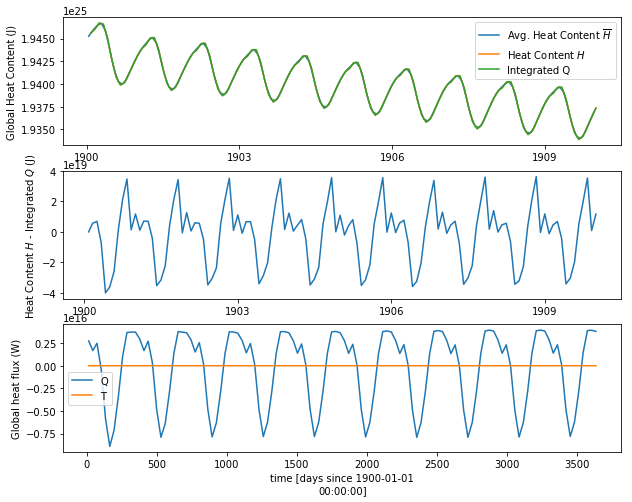

In [154]:
plt.figure(figsize=(10,8))
plt.subplot(3,1,1)
plt.plot(time_avg,(Hg).values,label='Avg. Heat Content $\overline{H}$')
plt.plot(time_snap,(Hsnapg).values,label='Heat Content $H$')
HfromQ = (Qg*dt).cumsum(dim='time').values
HfromQ[1:] = Hsnapg[0].values+HfromQ[1:]-HfromQ[0]
HfromQ[0] = Hsnapg[0].values
plt.plot(time_snap,HfromQ,label='Integrated Q')
plt.legend(loc=1)
plt.ylabel('Global Heat Content (J)')
plt.subplot(3,1,2)
plt.plot(time_snap,HfromQ-(Hsnapg).values,label='Heat Content $H$ - Integrated $Q$')
plt.ylabel('Heat Content $H$ - Integrated $Q$ (J)')
plt.subplot(3,1,3)
Qg.plot(label='Q')
Tg.plot(label='T')
plt.ylabel('Global heat flux (W)')
plt.legend()

## Heat Content Change between two snapshots

In [194]:
# options and coordinates
lon,lat = np.meshgrid(Q.xt_ocean.values,Q.yt_ocean.values)

t0 = 1
tf = len(time_snap.values)
t0str = str(time_snap.isel(time=t0-1).values)
tfstr = str(time_snap.isel(time=tf-1).values)

ta0 = t0
taf = t0+12
TA = T.isel(time=slice(ta0,taf+1)).mean('time')

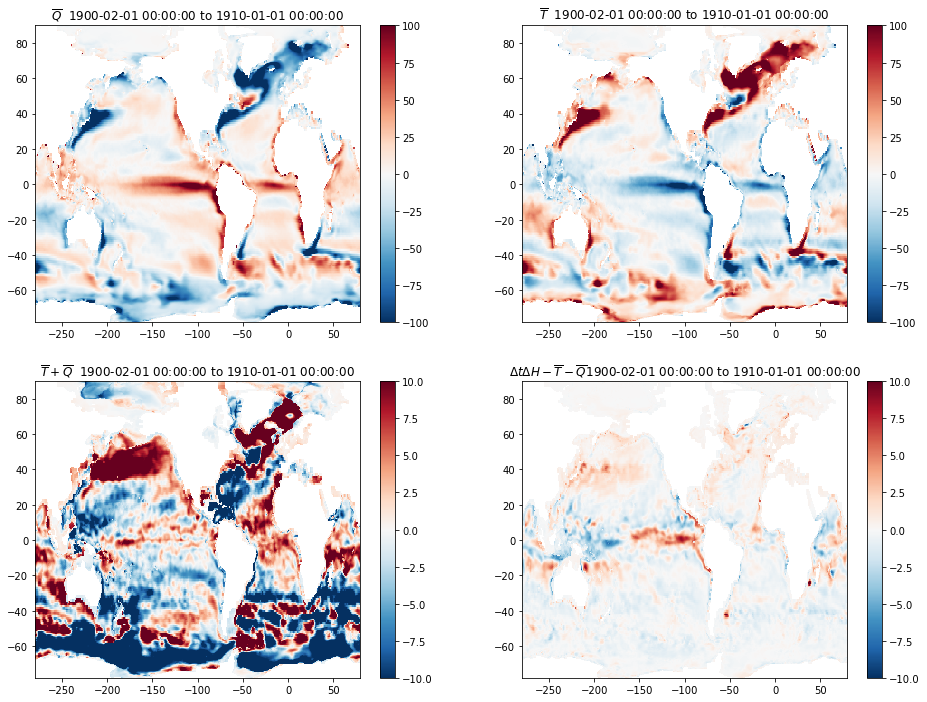

In [186]:
plt.figure(figsize=(16,12))
plt.subplot(2,2,1)
plt.pcolormesh(lon,lat,Q.isel(time=slice(t0,tf)).mean('time').values,vmin=-100.,vmax=100.,cmap='RdBu_r')
plt.title('$\overline{Q}$  ' + t0str + ' to ' + tfstr)
plt.colorbar()
plt.subplot(2,2,2)
plt.pcolormesh(lon,lat,T.isel(time=slice(t0,tf)).mean('time').values,vmin=-100.,vmax=100.,cmap='RdBu_r')
plt.title('$\overline{T}$  ' + t0str + ' to ' + tfstr)
plt.colorbar()
plt.subplot(2,2,3)
plt.pcolormesh(lon,lat,T.isel(time=slice(t0,tf)).mean('time').values+Q.isel(time=slice(t0,tf)).mean('time').values,vmin=-10.,vmax=10.,cmap='RdBu_r')
plt.title('$\overline{T}+\overline{Q}$  ' + t0str + ' to ' + tfstr)
plt.colorbar()
plt.subplot(2,2,4)
DT = dt.isel(time=slice(t0,tf)).sum('time').values
plt.pcolormesh(lon,lat,((Hsnap.isel(time=tf-1)-Hsnap.isel(time=t0-1))/DT).values-
               T.isel(time=slice(t0,tf)).mean('time').values-Q.isel(time=slice(t0,tf)).mean('time').values,vmin=-10.,vmax=10.,cmap='RdBu_r')
plt.title('$\Delta t\Delta H - \overline{T}-\overline{Q}$' + t0str + ' to ' + tfstr)
plt.colorbar()

## Change using a subtracted average T:

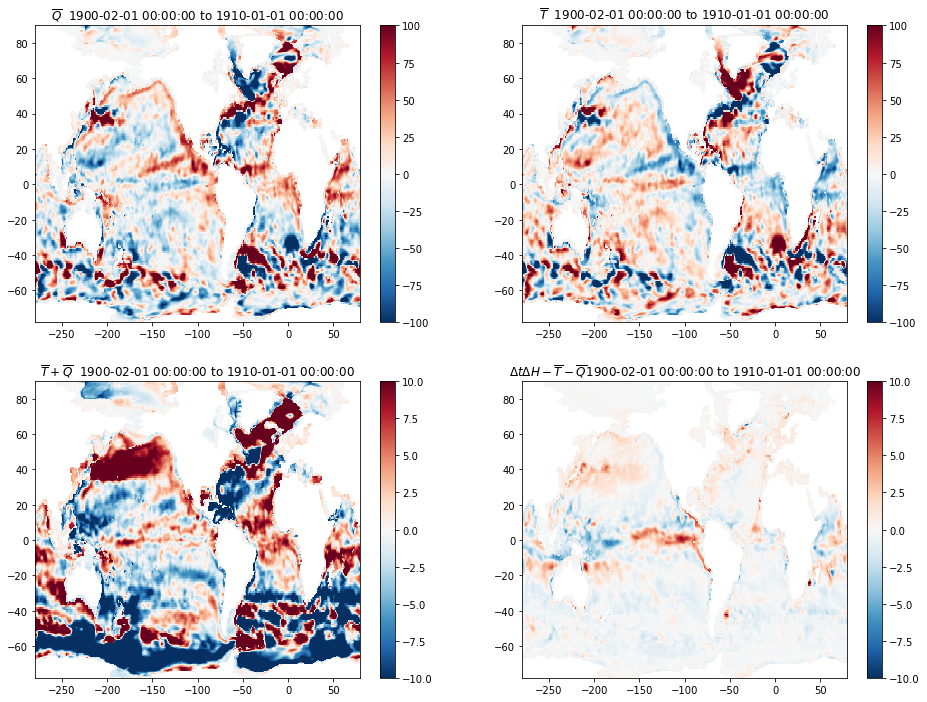

In [195]:
plt.figure(figsize=(16,12))
plt.subplot(2,2,1)
plt.pcolormesh(lon,lat,Q.isel(time=slice(t0,tf)).mean('time').values+TA.values,vmin=-100.,vmax=100.,cmap='RdBu_r')
plt.title('$\overline{Q}$  ' + t0str + ' to ' + tfstr)
plt.colorbar()
plt.subplot(2,2,2)
plt.pcolormesh(lon,lat,T.isel(time=slice(t0,tf)).mean('time').values-TA.values,vmin=-100.,vmax=100.,cmap='RdBu_r')
plt.title('$\overline{T}$  ' + t0str + ' to ' + tfstr)
plt.colorbar()
plt.subplot(2,2,3)
plt.pcolormesh(lon,lat,T.isel(time=slice(t0,tf)).mean('time').values+Q.isel(time=slice(t0,tf)).mean('time').values,vmin=-10.,vmax=10.,cmap='RdBu_r')
plt.title('$\overline{T}+\overline{Q}$  ' + t0str + ' to ' + tfstr)
plt.colorbar()
plt.subplot(2,2,4)
DT = dt.isel(time=slice(t0,tf)).sum('time').values
plt.pcolormesh(lon,lat,((Hsnap.isel(time=tf-1)-Hsnap.isel(time=t0-1))/DT).values-
               T.isel(time=slice(t0,tf)).mean('time').values-Q.isel(time=slice(t0,tf)).mean('time').values,vmin=-10.,vmax=10.,cmap='RdBu_r')
plt.title('$\Delta t\Delta H - \overline{T}-\overline{Q}$' + t0str + ' to ' + tfstr)
plt.colorbar()

## Averaging over end periods:

In [1]:
#yrsst = ['1993','1999']
#yrsen = ['2011','2017']
yrsst = ['1993','2004']
yrsen = ['2005','2017']

Qh = Q+T.sel(time=slice('1970','2017')).mean('time')
Th = T-T.sel(time=slice('1970','2017')).mean('time')

Qdtp1 = (Qh*dt).sel(time=slice(yrsst[0],yrsst[1]))
Tdtp1 = (Th*dt).sel(time=slice(yrsst[0],yrsst[1]))

Qp1 = -Qdtp1.cumsum('time').mean('time')
Tp1 = -Tdtp1.cumsum('time').mean('time')

Qdtp2 = (Qh*dt).sel(time=slice(yrsen[0],yrsen[1]))
Tdtp2 = (Th*dt).sel(time=slice(yrsen[0],yrsen[1]))

Qp2 = -(Qdtp2.sum('time')-Qdtp2.cumsum('time')).mean('time')
Tp2 = -(Tdtp2.sum('time')-Tdtp2.cumsum('time')).mean('time')

dH = (H.sel(time=slice(yrsen[0],yrsen[1])).mean('time')-H.sel(time=slice(yrsst[0],yrsst[1])).mean('time'))

Qtot = (Qh*dt).sel(time=slice(yrsst[0],yrsen[1])).sum('time')
Ttot = (Th*dt).sel(time=slice(yrsst[0],yrsen[1])).sum('time')

plt.figure(figsize=(16,18))
plt.subplot(3,2,1)
dH.plot(vmin=-0.3e10,vmax=0.3e10,cmap='RdBu_r')
plt.title('$\Delta H$ ' + yrsst[0] + ' - ' + yrsst[1] + ' to ' + yrsen[0] + ' - ' + yrsen[1])
plt.subplot(3,2,2)
Qtot.plot(vmin=-0.3e10,vmax=0.3e10,cmap='RdBu_r')
plt.title('$\overline{Q}$ ' + yrsst[0] + ' - ' + yrsen[1])
plt.subplot(3,2,3)
Ttot.plot(vmin=-0.3e10,vmax=0.3e10,cmap='RdBu_r')
plt.title('$\overline{T}$ ' + yrsst[0] + ' - ' + yrsen[1])
plt.subplot(3,2,4)
(Qtot+Ttot).plot(vmin=-0.3e10,vmax=0.3e10,cmap='RdBu_r')
plt.title('$\overline{T}+\overline{Q}$ ' + yrsst[0] + ' - ' + yrsen[1])
plt.subplot(3,2,5)
(Qp1+Qp2+Tp1+Tp2).plot(vmin=-0.3e10,vmax=0.3e10,cmap='RdBu_r')
plt.title('Avg. Period terms')
plt.subplot(3,2,6)
(Qtot+Ttot+Qp1+Qp2+Tp1+Tp2).plot(vmin=-0.3e10,vmax=0.3e10,cmap='RdBu_r')
plt.title('Total Change H')

NameError: name 'Q' is not defined